## Practice 02: Dealing with texts using CNN

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/logos/front_page.png" width=400px>

Based on YSDA [materials](https://github.com/yandexdataschool/nlp_course/blob/master/week02_classification/seminar.ipynb). _Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0). 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
# Do this only once
!curl -L "https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1" -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   145    0   145    0     0    336      0 --:--:-- --:--:-- --:--:--   336
100   342  100   342    0     0    384      0 --:--:-- --:--:-- --:--:--   384
100  119M  100  119M    0     0  9942k      0  0:00:12  0:00:12 --:--:-- 15.4M
Train_rev1.csv


In [3]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

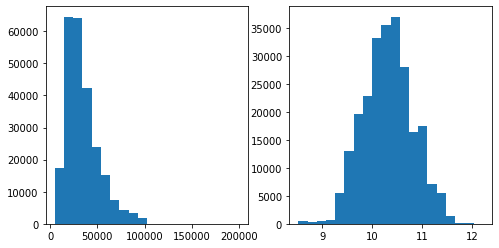

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
205314,72117201,QCF/Apprenticeship Assessor Health Social Care,QCF/Apprenticeship Assessor Health & Social C...,"Lancashire, North West",Lancashire,NaN,permanent,Strawberry Recruitment Solutions,Teaching Jobs,24000/annum,24000,cv-library.co.uk,10.085851
65945,68711986,BRANCH MANAGER,BRANCH MANAGER An established travel reservati...,East London London South East,South East London,NaN,permanent,Prospects4Leisure Travel,Travel Jobs,"Up to 25,000 per annum OTE 30k",25000,totaljobs.com,10.126671
112941,69731086,"NAV Support Analyst ****k Yorkshire, Manufactu...","MS Dynamics NAV Support Analyst, ****k, N. Yor...",Keighley West Yorkshire Yorkshire and the Humber,Keighley,NaN,permanent,NaN,IT Jobs,40000,40000,technojobs.co.uk,10.596660


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [6]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [7]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

# see task above
def normalize(text):
    # <YOUR CODE HERE>
    text = str(text).lower()
    tokens = tokenizer.tokenize(text)
    return ' '.join(tokens)

data[text_columns] = data[text_columns].applymap(normalize)

Now we can assume that our text is a space-separated list of tokens:

In [8]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [9]:
# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }
from collections import Counter
from tqdm import tqdm as tqdm


# <YOUR CODE HERE>
token_counts = Counter()
for sent in data[text_columns].values.flatten():
    token_counts.update(sent.split(' '))  # make joined words splitted back
# hint: you may or may not want to use collections.Counter

In [10]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


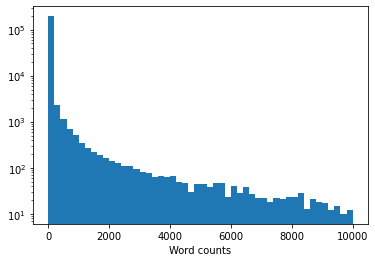

In [11]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Now filter tokens a list of all tokens that occur at least 10 times.

In [12]:
token_counts

Counter({'engineering': 68563,
         'systems': 77071,
         'analyst': 34427,
         'dorking': 260,
         'surrey': 8237,
         'salary': 93465,
         '****': 681869,
         'k': 77920,
         'our': 223441,
         'client': 198691,
         'is': 599665,
         'located': 7667,
         'in': 1035792,
         ',': 2318606,
         'and': 2657388,
         'are': 428534,
         'looking': 155766,
         'for': 867233,
         'provides': 11180,
         'specialist': 41160,
         'software': 74918,
         'development': 168938,
         'keywords': 4554,
         'mathematical': 1033,
         'modelling': 6534,
         'risk': 26638,
         'analysis': 34076,
         'system': 35689,
         'optimisation': 2801,
         'miser': 8,
         'pioneeer': 1,
         'stress': 1855,
         'engineer': 94623,
         'glasgow': 3333,
         'to': 2019884,
         'we': 238825,
         're': 17471,
         'currently': 54542,
         '

In [13]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, cnt in token_counts.items() if cnt >= min_count]# <YOUR CODE HERE>

In [14]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [15]:
# You have already done that ;)

token_to_id = {token: idx for idx, token in enumerate(tokens)} # <YOUR CODE HERE>

In [16]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [17]:
10 or float('inf')
None or float('inf')

inf

In [18]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))  # placeholder matrix filled with <PAD> tokens
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [19]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [20]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [21]:
data[categorical_columns].nunique()

Category                 29
Company               20813
LocationNormalized     2732
ContractType              3
ContractTime              3
dtype: int64

In [23]:
# How does DictVectorizer work.....

from sklearn.feature_extraction import DictVectorizer

cat_vec = DictVectorizer(dtype=np.float32, sparse=False)

import pandas as pd

df = pd.DataFrame({'col1': ['a', 'c', 'b', 'a'],
                   'col2': ['aa', 'cd', 'bs', 'aa'],
                   'col3': [1,2,3,4]
                   })
df

,col1,col2,col3
0,a,aa,1
1,c,cd,2
2,b,bs,3
3,a,aa,4


In [25]:
df.apply(dict, axis=1)
cat_vec.fit_transform(df.apply(dict, axis=1))

array([[1., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1., 2.],
       [0., 1., 0., 0., 1., 0., 3.],
       [1., 0., 0., 1., 0., 0., 4.]], dtype=float32)

In [26]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data_train['Company']).most_common(1000))  # unzipping dict into 2 lists
recognized_companies = set(top_companies)
data_train["Company"] = data_train["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")
data_val["Company"] = data_val["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data_train[categorical_columns].apply(dict, axis=1))

corpus = [' '.join(line) for line in data_train[categorical_columns].applymap(lambda x: x.replace(' ', '')).values]
print('\n', corpus[:2], '\n')

stopwords_eng = stopwords.words('english') + ['nan']
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_eng)
tfidf_vectorizer.fit(corpus)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



 ['Healthcare&NursingJobs Other Taunton NaN permanent', 'Scientific&QAJobs SCIRecruitmentforScientists NorthWestLondon NaN permanent'] 



TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [27]:
data[categorical_columns].nunique()

Category                 29
Company               20813
LocationNormalized     2732
ContractType              3
ContractTime              3
dtype: int64

In [28]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a neural-network-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical_dict'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    corpus = [' '.join(line) for line in data[categorical_columns].applymap(lambda x: x.replace(' ', '')).values]
    batch['Categorical_tfidf'] = tfidf_vectorizer.transform(corpus).toarray()
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    """
    With proba = keep_prop leaves element of matrix untouched. With proba = 1-keep_prop
    changes it into replace_with value.
    In default setting randomly changes matrix elements into UNKs
    """
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [31]:
# How choice works
keep_prop = 0.5
matrix = np.random.randn(2, 2)
print(matrix)
print(np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop]), '\n')

# How choose works
choices = [[0, 1, 2, 3], 
           [10, 11, 12, 13],
           [20, 21, 22, 23], 
           [30, 31, 32, 33]]
np.choose([2, 3, 1, 0], choices)
# the first element of the result will be the first element of the
# third (2+1) "array" in choices, namely, 20; the second element
# will be the second element of the fourth (3+1) choice array, i.e.,
# 31, etc.

[[ 0.98611212 -1.08364972]
 [-0.4788742   0.41462825]]
[[0 1]
 [1 0]] 



array([20, 31, 12,  3])

In [35]:
tmp = make_batch(data_train[:3], max_len=10)
{key: val.shape for key, val in tmp.items()}

{'Categorical_dict': (3, 3579),
 'Categorical_tfidf': (3, 3608),
 'FullDescription': (3, 10),
 'Log1pSalary': (3,),
 'Title': (3, 7)}

#### Architecture

Our main model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into PyTorch __Sequential__ interface. To build such a network, one will have to use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

But to start with let's build the simple model using only the part of the data. Let's create the baseline solution using only the description part (so it should definetely fit into the Sequential model).

In [36]:
import torch
from torch import nn
import torch.nn.functional as F

In [37]:
# You will need these to make it simple

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

To generate minibatches we will use simple pyton generator.

In [38]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

In [40]:
tmp = {'a': [1,32,4],
       'b': [4,5,6]}

tmp.pop('a')
tmp

{'b': [4, 5, 6]}

In [41]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)

In [42]:
batch, target

({'Categorical_dict': array([[0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  'Categorical_tfidf': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'FullDescription': array([[ 2412, 12587, 30847, ...,     1,     1,     1],
         [26986, 19045,  7538, ...,    82, 10570, 19045],
         [25625, 26986, 18864, ...,     1,     1,     1]], dtype=int32),
  'Title': array([[13093, 11312, 21660,     1,     1,     1],
         [26986, 19045,  7538,     1,     1,     1],
         [25625, 26986, 18864, 23774, 27627, 31867]], dtype=int32)},
 array([10.146473, 10.239996, 11.042938], dtype=float32))

**nn.Conv1d()**

\begin{array}{l}\text { - Input: }\left(N, C_{i n}, L_{i n}\right) \\ \text { - Output: }\left(N, C_{\text {out }}, L_{\text {out }}\right) \text { where } \\ L_{\text {out }}=\left\lfloor\frac{L_{\text {in }}+2 \times \text { padding }-\text { dilation } \times(\text { kernel_size }-1)-1}{\text { stride }}+1\right.\end{array}

in default case:
* padding=0
* dilation=1
* stride=1

$L_{out} = L_{in} -kernel\_size + 1$

In [43]:
# Here is some startup code:
n_tokens = len(tokens)
n_cat_features = len(categorical_vectorizer.vocabulary_)
hid_size = 64
n_maxs = 2
simple_model = nn.Sequential()

simple_model.add_module('emb', nn.Embedding(num_embeddings=n_tokens, 
                                            embedding_dim=hid_size)) # NxLXC; L-seq_len, C-embedding_dim
simple_model.add_module('reorder', Reorder())                        # NxCxL

# <YOUR CODE HERE>
simple_model.add_module('Conv1', nn.Conv1d(in_channels=hid_size, 
                                           out_channels=2*hid_size,
                                           kernel_size=3))           # Nx(2C)x(L-2)
simple_model.add_module('relu1', nn.ReLU())  # Nx(2C)x(L-2)
simple_model.add_module('Conv2', nn.Conv1d(in_channels=2*hid_size, 
                                           out_channels=2*hid_size,
                                           kernel_size=3))           # Nx(2C)x(L-4)
simple_model.add_module('relu2', nn.ReLU())                          # Nx(2C)x(L-4)
simple_model.add_module('bn1', nn.BatchNorm1d(2*hid_size))           # Nx(2C)x(L-4)
simple_model.add_module('adaptivepool', nn.AdaptiveMaxPool1d(n_maxs))# Nx(2C)xN_maxs; фактически, это overtime pooling

simple_model.add_module('flatten', nn.Flatten())                     # Nx(2*C*N_maxs)
simple_model.add_module('linear', nn.Linear(2*hid_size*n_maxs, 1))   # Nx1

In [44]:
batch['FullDescription'].shape

(3, 438)

In [45]:
tmp = simple_model(torch.tensor(batch['FullDescription']))
batch['FullDescription'].shape, tmp.shape

((3, 438), torch.Size([3, 1]))

__Remember!__ We are working with regression problem and predicting only one number.

In [46]:
# Try this to check your model. `torch.long` tensors are required for nn.Embedding layers.
simple_model(torch.tensor(batch['FullDescription'], dtype=torch.long))

tensor([[-2.3444],
        [-3.4162],
        [-1.0199]], grad_fn=<AddmmBackward0>)

And now simple training pipeline:

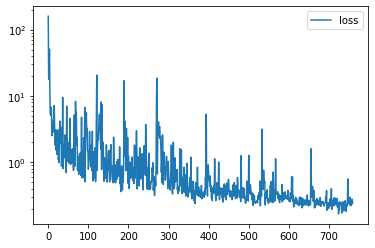

In [47]:
from IPython.display import clear_output
from random import sample
from tqdm.auto import tqdm


epochs = 1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model = simple_model.to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()  # <YOUR CODE HERE>

history = []
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_minibatches(data_train)):
        # Preprocessing the batch data and target
        batch = torch.tensor(batch['FullDescription'], dtype=torch.long).to(device)
        target = torch.tensor(target).to(device)

        predictions = model(batch)
        predictions = predictions.view(predictions.size(0))

        loss =  loss_func(predictions, target)  # <YOUR CODE HERE>

        # train with backprop
        # <YOUR CODE HERE>
        opt.zero_grad()
        loss.backward()
        opt.step()

        history.append(loss.item())
        if (idx+1)%10==0:
            clear_output(True)
            plt.plot(history,label='loss')
            plt.yscale('log')
            plt.legend()
            plt.show()

To evaluate the model it can be switched to `eval` state.

In [48]:
simple_model.eval()

Sequential(
  (emb): Embedding(34158, 64)
  (reorder): Reorder()
  (Conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (relu1): ReLU()
  (Conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu2): ReLU()
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (adaptivepool): AdaptiveMaxPool1d(output_size=2)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

Let's check the model quality.

In [49]:
batch_size=256

In [50]:
 def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in tqdm(iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw)):
        batch = torch.tensor(batch_x['FullDescription'], dtype=torch.long).to(device)
        batch_pred = model(batch)[:, 0].detach().cpu().numpy()
        squared_error += np.sum(np.square(np.exp(batch_pred) - np.exp(batch_y)))
        abs_error += np.sum(np.abs(np.exp(batch_pred) - np.exp(batch_y)))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Root mean square error: %.5f" % (squared_error / num_samples) ** 0.5)
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error/ num_samples, abs_error / num_samples

train_errors = print_metrics(simple_model, data_train, name='Train')
val_errors = print_metrics(simple_model, data_val, name='Val');

0it [00:00, ?it/s]

Train results:
Root mean square error: 21978.72043
Mean absolute error: 18109.91521


0it [00:00, ?it/s]

Val results:
Root mean square error: 22039.96469
Mean absolute error: 18048.13305


### Bonus area: three-headed network.

Now you can try to implement the network we've discussed above. Use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

In [51]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)

In [53]:
batch['Categorical_dict'].shape[1] == len(categorical_vectorizer.vocabulary_)

True

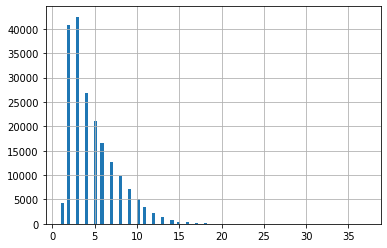

In [55]:
data_train['Title'].map(lambda x: len(x.split(' '))).hist(bins=100);

In [56]:
class DescriptionHead(nn.Module):
    def __init__(self, 
                 hid_size=64,  # embedding_dim
                 n_maxs=2,    # fixed seq len for every sample after applying MaxOverTime Pooling
                 n_tokens=len(tokens)):
        super().__init__()
        
        self.model = nn.Sequential(nn.Embedding(num_embeddings=n_tokens, 
                                                embedding_dim=hid_size) , # NxLXC; L-seq_len, C-embedding_dim
                                   Reorder(),                             # NxCxL
                                   nn.Conv1d(in_channels=hid_size, 
                                             out_channels=2*hid_size,
                                             kernel_size=3),           # Nx(2C)x(L-2)
                                   nn.ReLU(),                          # Nx(2C)x(L-2)
                                   nn.Conv1d(in_channels=2*hid_size, 
                                             out_channels=2*hid_size,
                                             kernel_size=3),           # Nx(2C)x(L-4)
                                   nn.ReLU(),                          # Nx(2C)x(L-4)
                                   nn.BatchNorm1d(2*hid_size),         # Nx(2C)x(L-4)
                                   nn.AdaptiveMaxPool1d(n_maxs),       # Nx(2C)xN_maxs; фактически, это overtime pooling
                                   nn.Flatten(),                       # Nx(2*C*N_maxs)
                                   )
    def forward(self, input):
        return self.model(input)


class TitleHead(nn.Module):
    def __init__(self, 
                 hid_size=64,  # embedding_dim
                 n_maxs=2,     # fixed seq len for every sample after applying MaxOverTime Pooling
                 n_tokens=len(tokens)):
        super().__init__()
        
        self.model = nn.Sequential(nn.Embedding(num_embeddings=n_tokens, 
                                                embedding_dim=hid_size) , # NxLXC; L-seq_len, C-embedding_dim
                                   Reorder(),                             # NxCxL
                                   nn.Conv1d(in_channels=hid_size, 
                                             out_channels=2*hid_size,
                                             kernel_size=2),           # Nx(2C)x(L-1)
                                   nn.ReLU(),                          # Nx(2C)x(L-2)
                                   nn.Conv1d(in_channels=2*hid_size, 
                                             out_channels=2*hid_size,
                                             kernel_size=2),           # Nx(2C)x(L-2)
                                   nn.ReLU(),                          # Nx(2C)x(L-2)
                                   nn.BatchNorm1d(2*hid_size),         # Nx(2C)x(L-2)
                                   nn.AdaptiveMaxPool1d(n_maxs),       # Nx(2C)xN_maxs; фактически, это overtime pooling
                                   nn.Flatten())                       # Nx(2*C*N_maxs)
    def forward(self, input):
        return self.model(input)


class CategoricalHead(nn.Module):
    def __init__(self, 
                 n_cat_features=len(categorical_vectorizer.vocabulary_), # shape[1] of batch['Categorical]
                 n_out=256,
                 ):
        super().__init__()
        
        self.model = nn.Sequential(nn.Linear(n_cat_features, 512),
                                   nn.BatchNorm1d(512),
                                   nn.ReLU(),
                                   nn.Linear(512, n_out))

    def forward(self, input):
        return self.model(input)


class ThreeInputsNet(nn.Module):
    def __init__(self, 
                 n_tokens=len(tokens),
                 n_cat_features=len(categorical_vectorizer.vocabulary_), 
                 hid_size=64,  # number of features representing each word 
                 n_maxs=2,  # fixed seq len for every sample after applying MaxOverTime Pooling
                 cat_n_out=256,  # size of categorical embedding
                 use_title=False,
                 use_categorical=False):
        super().__init__()

        self.use_title = use_title
        self.use_categorical = use_categorical

        self.description_head = DescriptionHead(n_tokens=n_tokens, n_maxs=n_maxs, hid_size=hid_size)
        self.title_head = TitleHead(n_tokens=n_tokens, n_maxs=n_maxs, hid_size=hid_size)
        self.category_head = CategoricalHead(n_cat_features, cat_n_out)

        # description_head + title_head + categorical_head
        feat_num = hid_size*2*n_maxs
        if self.use_title:
            feat_num += hid_size*2*n_maxs
        if self.use_categorical:
            feat_num += cat_n_out

        self.fc = nn.Sequential(nn.Linear(feat_num, 256),
                                nn.BatchNorm1d(256),
                                nn.ReLU(),
                                nn.Linear(256, 64),
                                nn.BatchNorm1d(64),
                                nn.ReLU(),
                                nn.Linear(64, 1))
        self.fc = nn.Sequential(nn.Linear(feat_num, 1))
        
    def forward(self, whole_input):
        input_description = whole_input['FullDescription']
        input_title = whole_input['Title']
        # input_cat = whole_input['Categorical_dict']
        input_cat = whole_input['Categorical_tfidf']
        
        if self.use_title:
            title = self.title_head(torch.tensor(input_title, dtype=torch.long))
        description = self.description_head(input_description)     
        if self.use_categorical:
            category = self.category_head(torch.tensor(input_cat, dtype=torch.float))     

        concatenated = description.clone()
        if self.use_title:
            concatenated = torch.cat([concatenated, title], dim=1)
        if self.use_categorical:
            concatenated = torch.cat([concatenated, category], dim=1)
        
        out = self.fc(concatenated)
        
        return out

In [57]:
class RunModel:
    def __init__(self, data_train, data_val, model, epochs=1, lr=0.001, plot_mode='print', device='cpu'):
        print(f'Using {device}')
        self.device = device
        self.plot_mode = plot_mode
        self.epochs = epochs

        self.model = model.to(device)
        self.opt = torch.optim.Adam(self.model.parameters(), lr=lr)  # not the best way to do
        self.loss_func = nn.MSELoss()                                # not the best way to do
        
        self.data_train = data_train
        self.data_val = data_val

    def train_loop(self):
        self.model.train()
        hist_tr_iter = []
        for idx, (batch, target) in enumerate(iterate_minibatches(self.data_train)):
            batch = {key: torch.tensor(val).to(self.device) for key, val in batch.items()}
            target = torch.tensor(target).to(self.device)

            predictions = self.model(batch).squeeze()
            loss = self.loss_func(predictions, target) 
            
            with torch.no_grad():
                metric = self.rmse_exp(target.cpu(), predictions.cpu())
                hist_tr_iter.append(metric)

            self.opt.zero_grad()
            loss.backward()
            self.opt.step()

        hist_tr_epoch = np.mean(hist_tr_iter)
        if self.plot_mode=='print':
            print(f'Train RMSE: {hist_tr_epoch:.0f}')

        return hist_tr_epoch

    def eval_loop(self):
        self.model.eval()
        hist_val_iter = []
        for idx, (batch, target) in enumerate(iterate_minibatches(self.data_val)):
            batch = {key: torch.tensor(val).to(self.device) for key, val in batch.items()}
            target = torch.tensor(target).to(self.device)

            predictions = self.model(batch).squeeze()
            loss = self.loss_func(predictions, target)

            with torch.no_grad():
                metric = self.rmse_exp(target.cpu(), predictions.cpu())
                hist_val_iter.append(metric)

            if (idx+1)%10==0:
                if self.plot_mode=='graph':
                    clear_output(True)
                    plt.plot(history,label='loss')
                    plt.yscale('log')
                    plt.legend()
                    plt.show()

        hist_val_epoch = np.mean(hist_val_iter)
        if self.plot_mode=='print':
            print(f'Val RMSE: {hist_val_epoch:.0f}\n')

        return hist_val_epoch

    def fit_model(self):
        hist_tr, hist_val = [], []

        for epoch_num in tqdm(range(self.epochs)):
            hist_tr_iter = self.train_loop()
            hist_tr.append(hist_tr_iter)

            hist_val_iter = self.eval_loop()
            hist_val.append(hist_val_iter)

        return hist_tr, hist_val

    def rmse_exp(self, true, predict):
        return torch.sqrt(torch.mean(torch.square(torch.exp(predict) - torch.exp(true))))

### Training only Description head

In [58]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [59]:
EPOCHS = 10
LR = 0.001  # 3e-4

model_uni = ThreeInputsNet(n_tokens=len(tokens),
                           n_cat_features=len(categorical_vectorizer.vocabulary_),
                           hid_size=64,
                           n_maxs=2,
                           cat_n_out=256,
                           use_title=False, 
                           use_categorical=False)
                            
run_model = RunModel(data_train, data_val, model_uni, epochs=EPOCHS, lr=LR, 
                     plot_mode='print', device=DEVICE)
hist_tr_epoch, hist_val_epoch = run_model.fit_model()

Using cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]

Train RMSE: 14745979
Val RMSE: 20533

Train RMSE: 17311
Val RMSE: 18224

Train RMSE: 15668
Val RMSE: 58052

Train RMSE: 15112
Val RMSE: 13896

Train RMSE: 14887
Val RMSE: 17246

Train RMSE: 13879
Val RMSE: 38796

Train RMSE: 13541
Val RMSE: 13187

Train RMSE: 13043
Val RMSE: 20487

Train RMSE: 12676
Val RMSE: 17561

Train RMSE: 12302
Val RMSE: 16289



### Training all 3 heads

In [61]:
import warnings
warnings.filterwarnings('ignore')

EPOCHS = 10
LR = 0.001  # 3e-4

model_3heads = ThreeInputsNet(n_tokens=len(tokens),
                                n_cat_features=len(tfidf_vectorizer.vocabulary_),
                                hid_size=64,
                                n_maxs=2,
                                cat_n_out=256,
                                use_title=True, 
                                use_categorical=True)
                            
run_model = RunModel(data_train, data_val, model_3heads, epochs=EPOCHS, lr=LR, 
                     plot_mode='print', device=DEVICE)
hist_tr_epoch, hist_val_epoch = run_model.fit_model()

Using cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]

Train RMSE: 43295
Val RMSE: 15581

Train RMSE: 14484
Val RMSE: 15664

Train RMSE: 12452
Val RMSE: 11733

Train RMSE: 12170
Val RMSE: 17089

Train RMSE: 11882
Val RMSE: 11552

Train RMSE: 11271
Val RMSE: 12666

Train RMSE: 10832
Val RMSE: 12903

Train RMSE: 10505
Val RMSE: 11060

Train RMSE: 10630
Val RMSE: 10662

Train RMSE: 10289
Val RMSE: 90373



### Use only 2 heads out of 3: Title & Description

In [62]:
import warnings
warnings.filterwarnings('ignore')

EPOCHS = 15
LR = 0.001  # 3e-4

model_3heads = ThreeInputsNet(n_tokens=len(tokens),
                                n_cat_features=len(tfidf_vectorizer.vocabulary_),
                                hid_size=64,
                                n_maxs=2,
                                cat_n_out=256,
                                use_title=True, 
                                use_categorical=False)
                            
run_model = RunModel(data_train, data_val, model_3heads, epochs=EPOCHS, lr=LR, 
                     plot_mode='print', device=DEVICE)
hist_tr_epoch, hist_val_epoch = run_model.fit_model()

Using cuda:0


  0%|          | 0/15 [00:00<?, ?it/s]

Train RMSE: 8751125
Val RMSE: 15698

Train RMSE: 15382
Val RMSE: 13673

Train RMSE: 13820
Val RMSE: 13530

Train RMSE: 13089
Val RMSE: 11961

Train RMSE: 12385
Val RMSE: 18016

Train RMSE: 12105
Val RMSE: 12210

Train RMSE: 11885
Val RMSE: 16471

Train RMSE: 11480
Val RMSE: 11477

Train RMSE: 11016
Val RMSE: 13840

Train RMSE: 11529
Val RMSE: 20326

Train RMSE: 10532
Val RMSE: 10452

Train RMSE: 10344
Val RMSE: 11358

Train RMSE: 10193
Val RMSE: 28116

Train RMSE: 9899
Val RMSE: 11228

Train RMSE: 9834
Val RMSE: 10675



### Bonus area 2: comparing RNN to CNN
Try implementing simple RNN (or LSTM) and applying it to this task. Compare the quality/performance of these networks. 
*Hint: try to build networks with ~same number of paremeters.*

In [ ]:
# <YOUR CODE HERE>

### Bonus area 3: fixing the data leaks
Fix the data leak we ignored in the beginning of the __Deep Learning part__. Compare results with and without data leaks using same architectures and training time.


In [ ]:
# <YOUR CODE HERE>

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)